## In this tutorial:
* What is a Neural Net?
* Prepairing data for NN
* Defining NN model (introducing keras..)
* Evaluation and Results
* Submition

## 1) What is a Neural Net?

Just kidding, everyone knows it)

Here is the definition from Wikipedia:

A neural network (NN), in the case of artificial neurons called artificial neural network (ANN) or simulated neural network (SNN), is an interconnected group of natural or artificial neurons that uses a mathematical or computational model for information processing based on a connectionistic approach to computation. In most cases an ANN is an adaptive system that changes its structure based on external or internal information that flows through the network.

Basicly, this picture shows the whole philosophy of Neural Nets
![](https://www.neuraldesigner.com/images/deep_neural_network_big.png)

So we take some inputs, combine them with a some weights, apply some kind of non-linear transformation, then pass the data to next layer and so on...

Some usefull resources:
* [video by 3Blue1Brown](https://www.youtube.com/watch?v=aircAruvnKk)
* [www.deeplearning.ai](https://www.deeplearning.ai/)
* [cs231n Stanford Course](http://cs231n.github.io/)
* and many more...

## 2) Prepairing data for NN

Nothing special in preparing data for NN, we can easily feed NN with our tabular data with numeric values. 

First, let's import our data. 

PS: we will be importing required packadges on the fly..

In [1]:
import os
import pandas as pd

PATH_TO_DATA = '../input'

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'train_features.csv'), 
                                    index_col='match_id_hash')

df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            'train_targets.csv'), 
                                   index_col='match_id_hash')

df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            'test_features.csv'), 
                                   index_col='match_id_hash')

Let's use some short notations:

In [2]:
X = df_train_features
y = df_train_targets['radiant_win'].astype('int') #models prefer numbers instead of True/False labels
test = df_test_features

We will need to evaluate the NN model on a validation set to see the performance. So, let's divide our train data (X) to train and validation sets:

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.25, random_state=17, 
                                                      shuffle=True, stratify=y)

Let's confirm dimensions visualy:

In [4]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((29756, 245), (9919, 245), (29756,), (9919,))

That's all! Our data is ready)

## 3) Defining NN model

In this tutorial we will implement Neural Network using Keras.

**Keras** is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.

More info about keras is [here](https://keras.io/)

First, let's import keras packages...

In [5]:
#we will use Sequential model, where we can add layers easily
from keras.models import Sequential

#now we import different layer types to use in our model
from keras.layers import Dense, Activation, Dropout, BatchNormalization

#we will have to optimize the model, so
from keras import optimizers

#tools to control overfitting
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


We can run keras model on GPU to accelerate computations. To do so, firstly, we have to switch on GPU (it is in the settings, on the right side of the kaggle kernel) and check whether we are on GPU:

In [6]:
#is keras on gpu?
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Keras NN model can be evaluated on lots of metrics with just passing the metric name, but it is not the case for ROC_AUC score, so we will define our own auc metric function:

In [7]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

### Finally, it's time to define the model itself:

In [8]:
model = Sequential() #we define the model

#first layer
model.add(Dense(512,input_dim=X_train.shape[1])) #basicly,245x512 matrix of weights
model.add(BatchNormalization()) #makes NN learning easier
model.add(Activation('relu')) #applying non-linear transformation
model.add(Dropout(0.2)) #say no to overfitting

#second layer
model.add(Dense(256)) #here we don't have to specify its input_dim, it knows it from previous layer automaticly
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

#third layer
model.add(Dense(256)) #here we don't have to specify its input_dim, it knows it from previous layer automaticly
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

#you can experiment with the number of layers as well...

#now the final layer to convert everything to one number(probability)
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


That's all! Our model is ready! Lets see it once again:

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               125952    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
__________

Now, we will define optimizer and a callback:

In [10]:
#Adam optimizer, there others as well, like RMSProp
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)

#EarlyStop if things does not improve for some time
earlystop = EarlyStopping(monitor="val_auc", patience=20, verbose=1, mode='max')

In [11]:
#Telling the model what to do...
import tensorflow as tf
model.compile(optimizer=adam,loss='binary_crossentropy',metrics = [auc])  

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


## 4) Evaluation and Results

We will run the model using "history", so we will be able to see the performance by time

In [12]:
history = model.fit(X_train, y_train, validation_data = (X_valid,y_valid),\
                       epochs=20,batch_size=64,verbose=1,callbacks=[earlystop])

Instructions for updating:
Use tf.cast instead.
Train on 29756 samples, validate on 9919 samples
Epoch 1/20
29756/29756 [==============================] - 7s 239us/step - loss: 0.5627 - auc: 0.7447 - val_loss: 0.5277 - val_auc: 0.7775
Epoch 2/20
29756/29756 [==============================] - 6s 195us/step - loss: 0.5390 - auc: 0.7851 - val_loss: 0.5597 - val_auc: 0.7864
Epoch 3/20
29756/29756 [==============================] - 6s 194us/step - loss: 0.5329 - auc: 0.7886 - val_loss: 0.5538 - val_auc: 0.7902
Epoch 4/20
29756/29756 [==============================] - 6s 192us/step - loss: 0.5314 - auc: 0.7918 - val_loss: 0.5158 - val_auc: 0.7928
Epoch 5/20
29756/29756 [==============================] - 6s 192us/step - loss: 0.5306 - auc: 0.7940 - val_loss: 0.5201 - val_auc: 0.7948
Epoch 6/20
29756/29756 [==============================] - 6s 193us/step - loss: 0.5290 - auc: 0.7957 - val_loss: 0.5304 - val_auc: 0.7963
Epoch 7/20
29756/29756 [==============================] - 6s 196us/step - l

Surely, you can play with number of epochs, batch size, callbacks and other params

Now, after our model has been trained lets see its performance

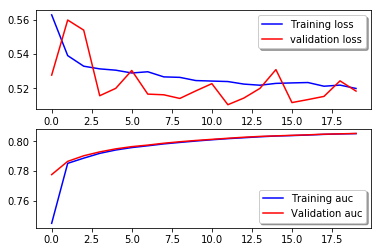

In [13]:
# Plot the loss and auc curves for training and validation 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['auc'], color='b', label="Training auc")
ax[1].plot(history.history['val_auc'], color='r',label="Validation auc")
legend = ax[1].legend(loc='best', shadow=True)

Hmm, validation loss looks funny at least).  We need to investigate more the learning curves and adjust the model properly. Andrew Ng explains learning curves in this [video](https://www.youtube.com/watch?v=ISBGFY-gBug)

## Prediction and Submition

In [14]:
#simply as it
predictions = model.predict(test)[:,0]

Let's see them

In [15]:
predictions

array([0.5288087 , 0.9177419 , 0.8940541 , ..., 0.4407952 , 0.54621243,
       0.16022754], dtype=float32)

Looks realistic)

### Submition

In [16]:
df_submission = pd.DataFrame({'radiant_win_prob': predictions}, 
                                 index=df_test_features.index)
import datetime
submission_filename = 'submission_{}.csv'.format(
    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
df_submission.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

Submission saved to submission_2019-04-03_19-04-57.csv


#### Hope this tutorial was useful, feel free fork, experiment and upvote.